# Feature Selection - Advanced methods
shoutout to 'Data Science With Marco' channel on youtube for this great video:
https://www.youtube.com/watch?v=hCwTDTdYirg&t=1324s

In [481]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_wine


In [482]:
plt.rcParams['figure.figsize'] = (12, 7)


In [483]:
wine_data = load_wine()

wine_df = pd.DataFrame(
	data=wine_data.data,
	columns=wine_data.feature_names
)

wine_df['target'] = wine_data.target

wine_df.head()


,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [484]:
swarm_data = pd.melt(wine_df[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'target']], var_name='feature', value_name='value', id_vars='target')

swarm_data


,target,feature,value
0,0,alcohol,14.23
1,0,alcohol,13.20
2,0,alcohol,13.16
3,0,alcohol,14.37
4,0,alcohol,13.24
...,...,...,...
529,2,alcalinity_of_ash,20.50
530,2,alcalinity_of_ash,23.00
531,2,alcalinity_of_ash,20.00
532,2,alcalinity_of_ash,20.00


<Axes: xlabel='feature', ylabel='value'>

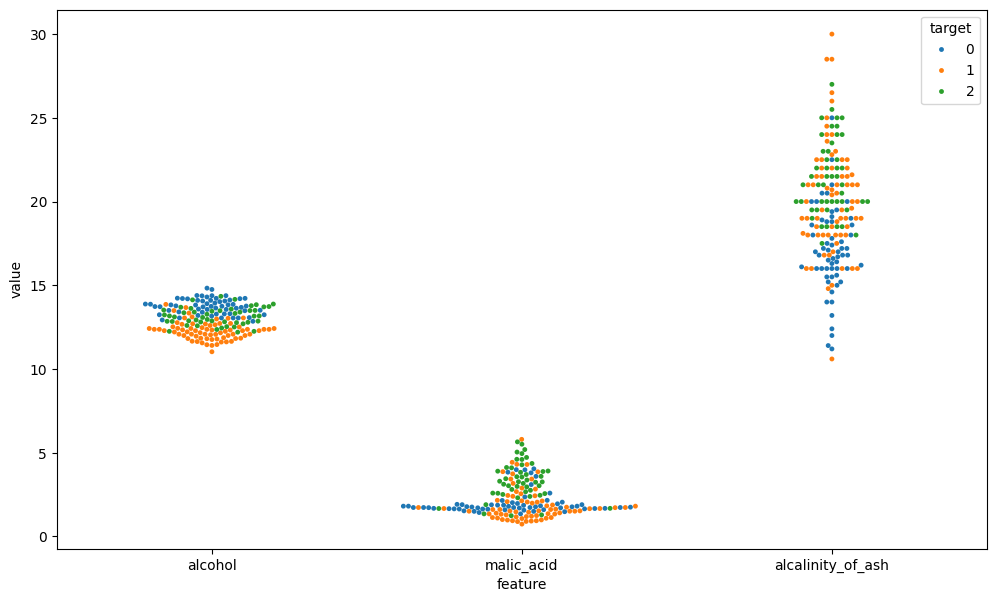

In [485]:
sns.swarmplot(
	swarm_data, x='feature', y='value', hue='target', palette='tab10', size=3.5
)


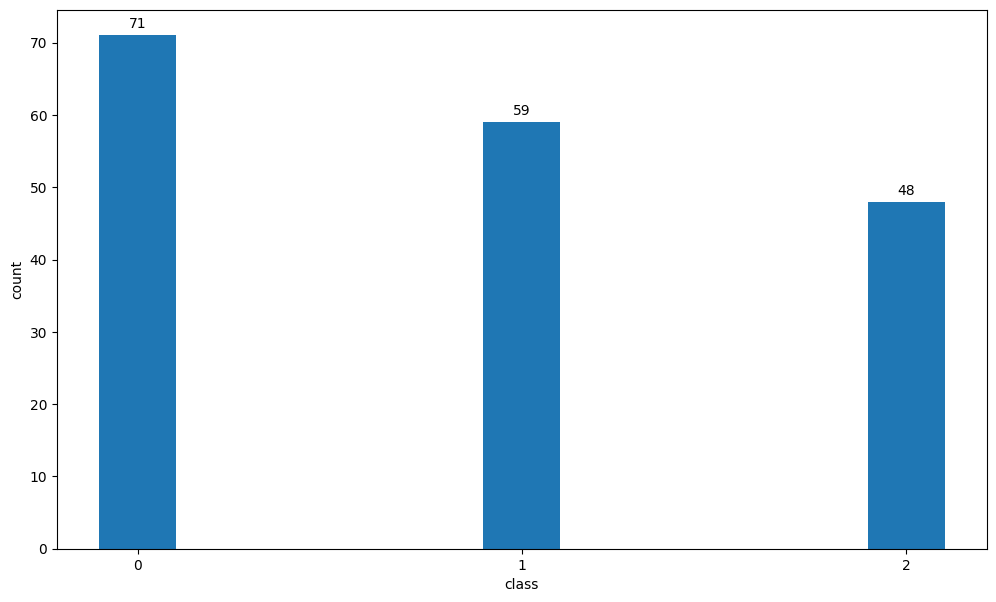

In [486]:
target_counts = wine_df['target'].value_counts()

plt.bar(range(len(target_counts)), target_counts, width=0.2)
plt.xlabel('class')
plt.ylabel('count')
plt.xticks(range(len(target_counts)))

for i, count in enumerate(target_counts):
	plt.text(x=i, y=count+1, s=str(count), ha='center')


In [487]:
from sklearn.model_selection import train_test_split

X = wine_df.drop(['target'], axis=1)
y = wine_df['target']

X_train, X_test, y_train, y_test = train_test_split(
	X, y, test_size=0.3, shuffle=True, stratify=y, random_state=42
)


### Baseline model

In [488]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score

model = GradientBoostingClassifier(max_depth=5, random_state=42)

# using all features
model.fit(X_train, y_train)

preds = model.predict(X_test)

score = f1_score(y_test, preds, average='weighted')
print(f'{score:.3f}')


0.908


### Feature Selection methods:
#### 1. Variance Threshold
The closer the variance of a feature is to zero, the less the model's prediction rely on that feature. And we may be able to drop that feature entirely.

In [489]:
# copy all the data
X_train_1, X_test_1, y_train_1, y_test_1 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()


In [490]:
# calculate the variance of each feature(column)
# without standardization, so not scaled
X_train.var(axis=0)


alcohol                             0.658341
malic_acid                          1.123507
ash                                 0.072433
alcalinity_of_ash                  11.471279
magnesium                         232.071532
total_phenols                       0.393226
flavanoids                          0.912299
nonflavanoid_phenols                0.013873
proanthocyanins                     0.335108
color_intensity                     5.669722
hue                                 0.052891
od280/od315_of_diluted_wines        0.470021
proline                         94906.710923
dtype: float64

In [491]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaled_X_train_1 = scaler.fit_transform(X_train_1)


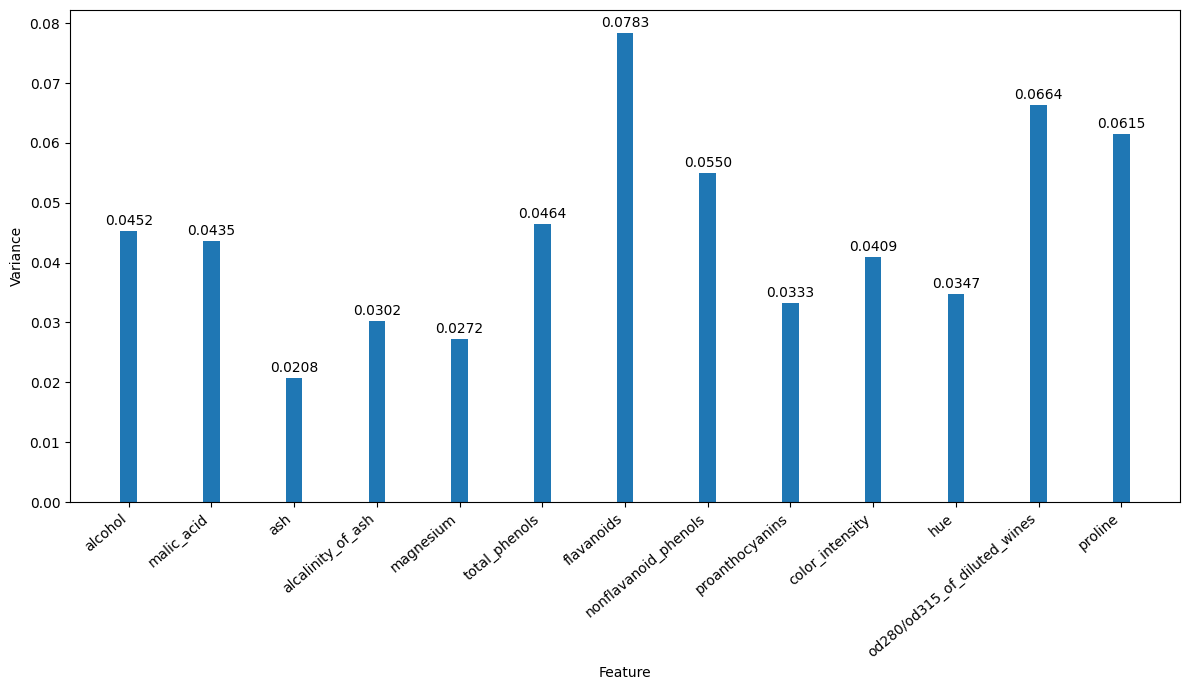

In [492]:
# plotting the new scaled variances
cols = X.columns
variances = scaled_X_train_1.var(axis=0)

plt.bar(cols, variances, width=0.2)
plt.xlabel('Feature')
plt.ylabel('Variance')

plt.xticks(rotation=40, ha='right')
plt.tight_layout()

for i, val in enumerate(variances):
	plt.text(x=i, y=val+1e-3, s=f'{val:.4f}', ha='center')


In [493]:
# if we manually set the variance threshold to something like 0.0311
var_threshold = 0.0311
features_to_drop = X.columns[variances <= var_threshold]
X_train_1 = X_train_1.drop(features_to_drop, axis=1)
X_test_1 = X_test_1.drop(features_to_drop, axis=1)
X_train_1


,alcohol,malic_acid,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
12,13.75,1.73,2.60,2.76,0.29,1.81,5.60,1.15,2.90,1320.0
30,13.73,1.50,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0
36,13.28,1.64,2.60,2.68,0.34,1.36,4.60,1.09,2.78,880.0
31,13.58,1.66,2.86,3.19,0.22,1.95,6.90,1.09,2.88,1515.0
120,11.45,2.40,2.90,2.79,0.32,1.83,3.25,0.80,3.39,625.0
...,...,...,...,...,...,...,...,...,...,...
168,13.58,2.58,1.55,0.84,0.39,1.54,8.66,0.74,1.80,750.0
114,12.08,1.39,2.56,2.29,0.43,1.04,2.90,0.93,3.19,385.0
152,13.11,1.90,2.20,1.28,0.26,1.56,7.10,0.61,1.33,425.0
136,12.25,4.72,1.38,0.47,0.53,0.80,3.85,0.75,1.27,720.0


In [494]:
# now let's test the new features
model.fit(X_train_1, y_train_1)

preds = model.predict(X_test_1)

score = f1_score(y_test_1, preds, average='weighted')

print(f'{score:.3f}')


0.963


#### 2. KBest Features
Based on the type(categorical or numerical) of the features and the target, there are several methods for finding the best features. but for all cases we can use Mutal Information.



In [495]:
# copy all the data
X_train_2, X_test_2, y_train_2, y_test_2 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()


In [496]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# calculate the f1-score for all different values of k to see which k is the best
scores = []

for k in range(1, len(X.columns)+1):
	selector = SelectKBest(score_func=mutual_info_classif, k=k)
	selector.fit(X_train_2, y_train_2)

	selected_X_train_2 = selector.transform(X_train_2)
	selected_X_test_2 = selector.transform(X_test_2)

	model.fit(selected_X_train_2, y_train_2)
	preds = model.predict(selected_X_test_2)

	scores.append(f1_score(y_test_2, preds, average='weighted'))


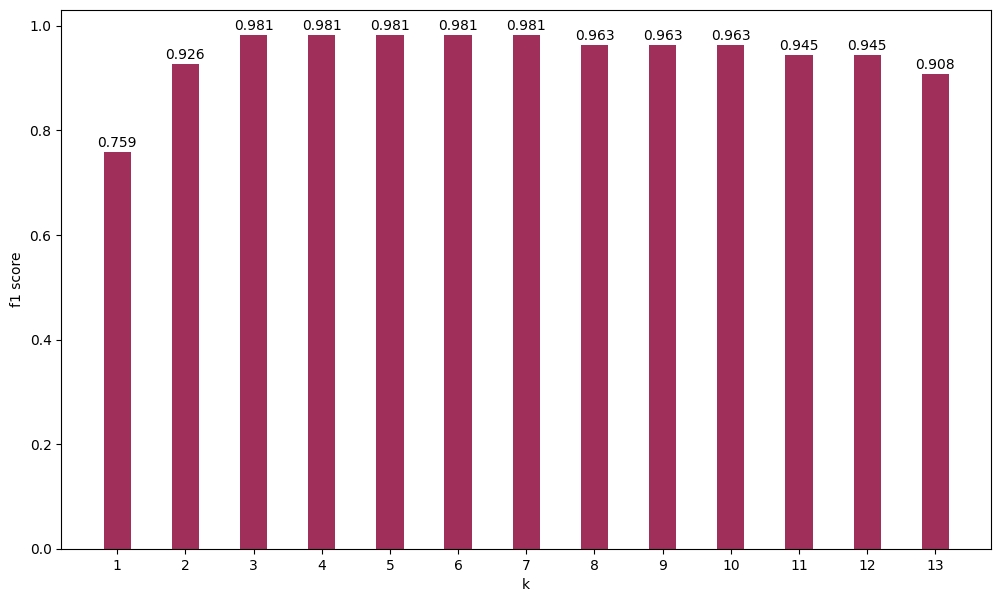

In [497]:
plt.bar(range(1, len(X.columns)+1), scores, width=0.4, color='#8a0033cf')
plt.xlabel('k')
plt.xticks(range(1, len(X.columns)+1))
plt.ylabel('f1 score')

for i, score in enumerate(scores, 1):
	plt.text(x=i, y=score+1e-2, s=f'{score:.3f}', ha='center')


In [498]:
# since 3 features results in a simpler model we will set k=3 for the model
selector = SelectKBest(mutual_info_classif, k=3)
selector.fit(X_train_2, y_train_2)

selector.get_feature_names_out()


array(['flavanoids', 'color_intensity', 'proline'], dtype=object)

#### 3. Recursive Feature Elimination (RFE)
works on tree-bases models like decision tree, random forest, gradient boost and ...

In [499]:
# copy all the data
X_train_3, X_test_3, y_train_3, y_test_3 = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()


In [ ]:
from sklearn.feature_selection import RFE

scores = []

for k in range(1, len(X.columns)+1):
	# step is the number of features to remove in each iteration
	rfe_selector = RFE(estimator=model, n_features_to_select=k, step=1)
	rfe_selector.fit(X_train_3, y_train_3)

	selected_X_train_3 = rfe_selector.transform(X_train_3)
	selected_X_test_3 = rfe_selector.transform(X_test_3)


	model.fit(selected_X_train_3, y_train_3)

	preds = model.predict(selected_X_test_3)

	score = f1_score(y_test_3, preds, average='weighted')
	scores.append(score)


1
2
3
4
5
6
7
8
9
10
11
12
13


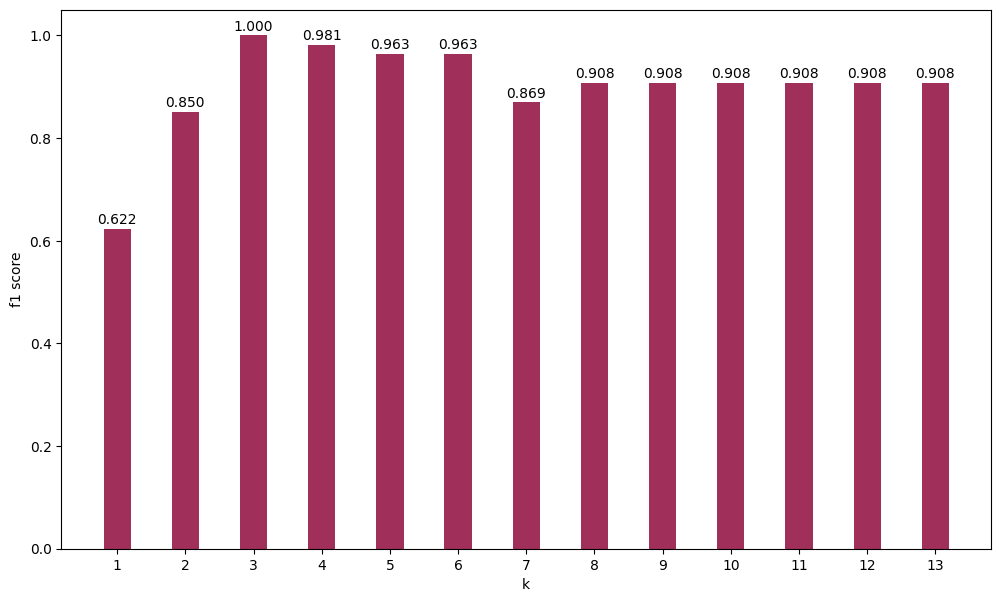

In [501]:
plt.bar(range(1, len(X.columns)+1), scores, width=0.4, color='#8a0033cf')
plt.xlabel('k')
plt.xticks(range(1, len(X.columns)+1))
plt.ylabel('f1 score')

for i, score in enumerate(scores, 1):
	plt.text(x=i, y=score+1e-2, s=f'{score:.3f}', ha='center')


In [502]:
rfe_selector = RFE(estimator=model, n_features_to_select=3, step=10)
rfe_selector.fit(X_train_3, y_train_3)

rfe_selector.get_feature_names_out()


array(['color_intensity', 'od280/od315_of_diluted_wines', 'proline'],
      dtype=object)